In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#important paths for data
#data_dir = '/home/ak30504/git_projects/m226/m226_final_proj/data/'
data_dir = '/media/raid/m226/'

dataset1_path = data_dir + 'GSE132257_GEO_natural_log_TPM_matrix.txt'
dataset1_annotations_path = data_dir + 'GSE132257_processed_protocol_and_fresh_frozen_cell_annotation.txt'

dataset2_path = data_dir + 'GSE132465_GEO_processed_CRC_10X_natural_log_TPM_matrix.txt'
dataset2_annotations_path = data_dir + 'GSE132465_GEO_processed_CRC_10X_cell_annotation.txt'

dataset3_path = data_dir + 'GSE144735_processed_KUL3_CRC_10X_natural_log_TPM_matrix.txt'
dataset3_annotations_path = data_dir + 'GSE144735_processed_KUL3_CRC_10X_annotation.txt'

In [2]:
pwd

'/home/ak30504/git_projects/m226/final_proj/m226_final_proj'

In [3]:
#load the annotations first
annotations1 = pd.read_csv(dataset1_annotations_path, header=0, sep='\t')
annotations2 = pd.read_csv(dataset2_annotations_path, header=0, sep='\t')
annotations3 = pd.read_csv(dataset3_annotations_path, header=0, sep='\t')

#count the number of normal and tumor cells in each dataset
counts1 = [annotations1['Class'].value_counts()[class_name] for class_name in annotations1['Class'].unique()]
counts2 = [annotations2['Class'].value_counts()[class_name] for class_name in annotations2['Class'].unique()]
counts3 = [annotations3['Class'].value_counts()[class_name] for class_name in annotations3['Class'].unique()]

classes_counts1 = dict(zip(annotations1['Class'].unique(), counts1))
print(classes_counts1)
classes_counts2 = dict(zip(annotations2['Class'].unique(), counts2))
print(classes_counts2)
classes_counts3 = dict(zip(annotations3['Class'].unique(), counts3))
print(classes_counts3)

#we see that the third dataset also has 'border' cells. we want to separate these out, maybe not use them in our project.

#get the indices associated with normal and tumor cells
    #can use these indices to grab the appropriate columns of the datasets below
dataset1_normal_ixs = annotations1.index[annotations1['Class']=='Normal'].values
dataset1_tumor_ixs = annotations1.index[annotations1['Class']=='Tumor'].values

dataset2_normal_ixs = annotations2.index[annotations2['Class']=='Normal'].values
dataset2_tumor_ixs = annotations2.index[annotations2['Class']=='Tumor'].values

dataset3_normal_ixs = annotations3.index[annotations3['Class']=='Normal'].values
dataset3_tumor_ixs = annotations3.index[annotations3['Class']=='Tumor'].values

{'Normal': 7686, 'Tumor': 10723}
{'Tumor': 47285, 'Normal': 16404}
{'Tumor': 8254, 'Border': 9424, 'Normal': 9736}


In [4]:
#we also want to see how many different types of cells we have: B cells, fibroblasts, mast cells, etc:
    #and the counts of each. if for example, we have thousands of T cells, and many examples of both
    #tumor and normal T cells, we should see if we can train a classifier just on this subset, as the
    #gene expression data should be much more similar/usable.

{'T cells': 7172, 'B cells': 4214, 'Stromal cells': 953, 'Epithelial cells': 4507, 'Myeloids': 1193, 'Mast cells': 239, 'Unspecified': 131}
{'Epithelial cells': 18539, 'Stromal cells': 5933, 'Myeloids': 6769, 'T cells': 23115, 'B cells': 9146, 'Mast cells': 187}
{'Epithelial cells': 6168, 'Stromal cells': 7650, 'Myeloids': 2676, 'T cells': 5770, 'B cells': 4902, 'Mast cells': 248}


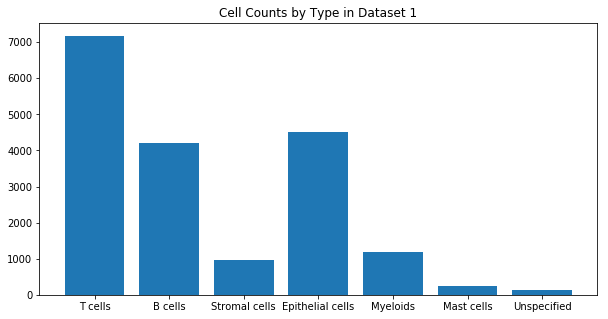

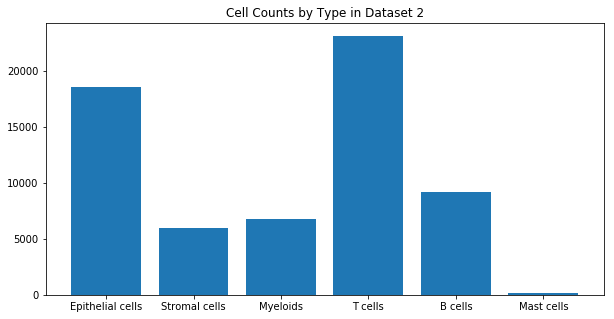

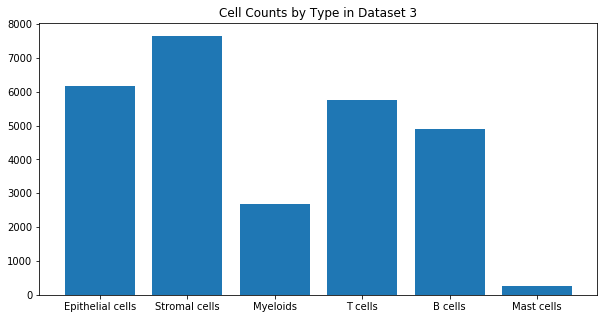

In [5]:
counts1 = [annotations1['Cell_type'].value_counts()[class_name] for class_name in annotations1['Cell_type'].unique()]
counts2 = [annotations2['Cell_type'].value_counts()[class_name] for class_name in annotations2['Cell_type'].unique()]
counts3 = [annotations3['Cell_type'].value_counts()[class_name] for class_name in annotations3['Cell_type'].unique()]

celltypes_counts1 = dict(zip(annotations1['Cell_type'].unique(), counts1))
print(celltypes_counts1)
celltypes_counts2 = dict(zip(annotations2['Cell_type'].unique(), counts2))
print(celltypes_counts2)
celltypes_counts3 = dict(zip(annotations3['Cell_type'].unique(), counts3))
print(celltypes_counts3)

#t_count = celltypes_counts1['T cells'] + celltypes_counts2['T cells'] + celltypes_counts3['T cells']
fig = plt.figure(figsize=(10,5))
plt.bar(range(len(celltypes_counts1)), list(celltypes_counts1.values()), align='center')
plt.xticks(range(len(celltypes_counts1)), list(celltypes_counts1.keys()))
plt.title('Cell Counts by Type in Dataset 1')
plt.show()

fig = plt.figure(figsize=(10,5))
plt.bar(range(len(celltypes_counts2)), list(celltypes_counts2.values()), align='center')
plt.xticks(range(len(celltypes_counts2)), list(celltypes_counts2.keys()))
plt.title('Cell Counts by Type in Dataset 2')
plt.show()

fig = plt.figure(figsize=(10,5))
plt.bar(range(len(celltypes_counts3)), list(celltypes_counts3.values()), align='center')
plt.xticks(range(len(celltypes_counts3)), list(celltypes_counts3.keys()))
plt.title('Cell Counts by Type in Dataset 3')
plt.show()

In [6]:
#What's the conclusion here? We have ~15k Stromal cells,
    #~30k epithelial cells, ~40k T cells, ~19k B cells across the three datasets.
    #I would think that with any of these subgroups we could train a classifier or do a UMAP.

In [7]:
%%time
dataset1 = pd.read_csv(dataset1_path, header=0, sep='\t')
#looks like the rows are genes, with the gene name appearing as the index. The subsequent columns are the cells,
    #and the values below each cell are the expression levels. This appears to be a fairly sparse set,
    #that is, most of the expression values for each gene are zero

#let's load the other two - these all take a long time to load. don't do this if you don't have many GBs of RAM
dataset2 = pd.read_csv(dataset2_path, header=0, sep='\t')
dataset3 = pd.read_csv(dataset3_path, header=0, sep='\t')

CPU times: user 56min 29s, sys: 1min 55s, total: 58min 25s
Wall time: 58min 16s


In [11]:
#I'm also worried about sparsity of the datasets - it appears that many of the values in each gene expression
    #matrix are = 0. Let's look into this more deeply and get a sense of it
    #What is the distribution of the number of non-zero values in each column (cell)?

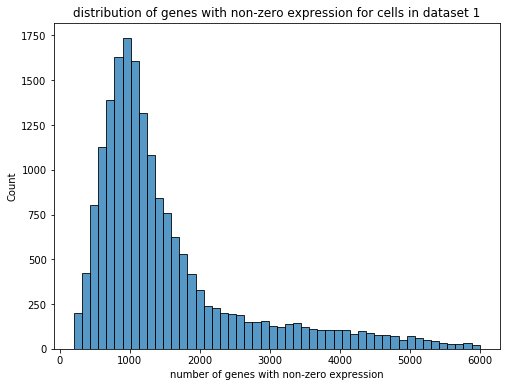

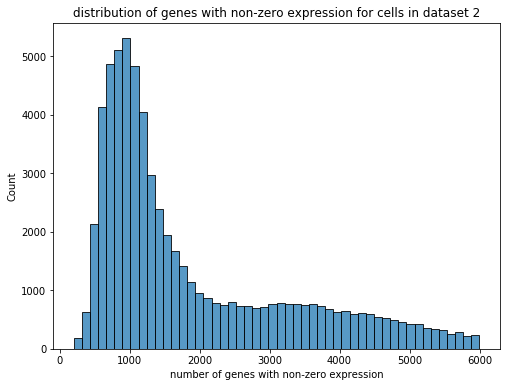

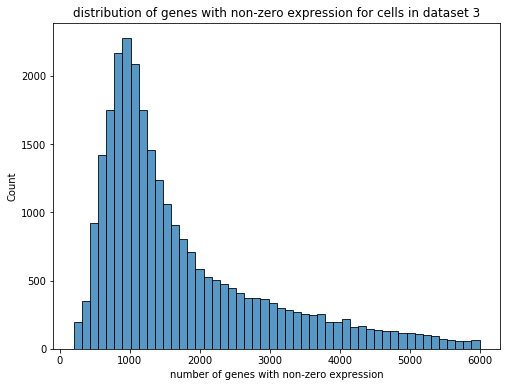

In [8]:
nonzero_vals1 = []
nonzero_vals2 = []
nonzero_vals3 = []

#in dataset 1, for each column
for col in dataset1.columns:
    #print(dataset1[col][0])
    #skip the first column bc it's the names of the genes
    if dataset1[col][0] == 'RP11-34P13.3':
        continue
    #now count the number of non-zero values
    nonzero_vals1.append(np.count_nonzero(dataset1[col]))
    
for col in dataset2.columns:
    #print(dataset1[col][0])
    #skip the first column bc it's the names of the genes
    if dataset2[col][0] == 'A1BG':
        continue
    #now count the number of non-zero values
    nonzero_vals2.append(np.count_nonzero(dataset2[col]))
    
for col in dataset3.columns:
    #print(dataset1[col][0])
    #skip the first column bc it's the names of the genes
    if dataset3[col][0] == 'RP11-34P13.3':
        continue
    #now count the number of non-zero values
    nonzero_vals3.append(np.count_nonzero(dataset3[col]))
    
plt.figure(figsize=(8, 6))
sns.histplot(data=nonzero_vals1, bins=50)
plt.title('distribution of genes with non-zero expression for cells in dataset 1')
plt.xlabel('number of genes with non-zero expression')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=nonzero_vals2, bins=50)
plt.title('distribution of genes with non-zero expression for cells in dataset 2')
plt.xlabel('number of genes with non-zero expression')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=nonzero_vals3, bins=50)
plt.title('distribution of genes with non-zero expression for cells in dataset 3')
plt.xlabel('number of genes with non-zero expression')
plt.show()

In [30]:
#sort rows alphabetically
dataset1_sorted = dataset1.sort_values('Index')
dataset3_sorted = dataset3.sort_values('Index')

dataset1_sorted_ixs = dataset1_sorted.index
print(dataset1_sorted_ixs)

dataset3_sorted_ixs = dataset3_sorted.index
print(dataset3_sorted_ixs)

Int64Index([32170, 32171, 19384, 20381, 20380, 20374, 20371, 20373,   699,
            32996,
            ...
             6447,  1011,  1010, 13182, 26843,  1227, 33190, 33189, 33188,
            26808],
           dtype='int64', length=33694)
Int64Index([32170, 32171, 19384, 20381, 20380, 20374, 20371, 20373,   699,
            32996,
            ...
             6447,  1011,  1010, 13182, 26843,  1227, 33190, 33189, 33188,
            26808],
           dtype='int64', length=33694)


In [35]:
#concatenate the 3 datasets together

combined_dataset = pd.concat([dataset1_sorted, dataset2, dataset3_sorted], axis=1)
combined_dataset

,Index,SMC13N.A1.F_AAACCTGAGATCGGGT,SMC13N.A1.F_AAACCTGAGGATTCGG,SMC13N.A1.F_AAACCTGGTACTCAAC,SMC13N.A1.F_AAACGGGAGCTTTGGT,SMC13N.A1.F_AAACGGGCATCCAACA,SMC13N.A1.F_AAACGGGTCATCGCTC,SMC13N.A1.F_AAAGATGAGCCACGTC,SMC13N.A1.F_AAAGATGAGCGTTCCG,SMC13N.A1.F_AAAGATGAGTAGGTGC,...,KUL30-N_TGGACGCCATCCTAGA,KUL30-N_TTAGGACCATCTACGA,KUL30-N_TTTGGTTCAAGCGCTC,KUL31-N_CAACTAGCACATGTGT,KUL31-N_CAGCATAGTCATGCAT,KUL31-N_CGCTTCAGTGGTCCGT,KUL31-N_CTGTTTAAGGGTTCCC,KUL31-N_GCCTCTATCGCGGATC,KUL31-N_GGGATGATCACCTCGT,KUL31-N_TTAGTTCTCGGTCCGA
0,RP11-34P13.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
1,FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
2,OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
3,RP11-34P13.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
4,RP11-34P13.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
5,RP11-34P13.14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
6,RP11-34P13.9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
7,FO538757.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000
8,FO538757.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.626550,0.0000,0.00000,1.423970,0.000000,2.291412,0.000000
9,AP006222.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000


In [47]:
sample_names = tuple(annotations1['Index'].values)
# For some reason the names are different in the metadata and the expression files
sample_names = [x.replace('-', '.') for x in sample_names]
gene_expression = dataset1[sample_names].T
print(gene_expression.shape)
tumor_labels = annotations1['Class']
tumor_labels.shape

(18409, 33694)


(18409,)

In [33]:
labels_map = {'Normal':0, 'Tumor': 1}

In [55]:
print(np.unique(tumor_labels))
tumor_labels_n = [labels_map[l] for l in tumor_labels]

['Normal' 'Tumor']


## Dimensionality reduction
### PCA

In [10]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=2).fit(gene_expression)


In [49]:
gene_e_pca = pca.transform(gene_expression)

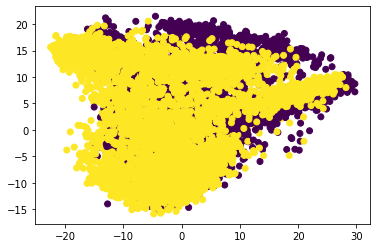

In [56]:
plt.scatter(gene_e_pca[:, 0], gene_e_pca[:, 1], c=tumor_labels_n)

### Logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
%%time
lr = LogisticRegression().fit(gene_expression, tumor_labels_n)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
y_pred = lr.predict(gene_expression)

In [72]:
print('accuracy: ', (y_pred==tumor_labels_n).mean())

accuracy:  1.0


### Logreg with k components

In [86]:
K = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])
all_components = PCA(n_components=K[-1]).fit_transform(gene_expression)

In [87]:
accuracies = np.empty(len(K))
for i, k in enumerate(K):
    print('K =', k)
    components = all_components[:, :k]
    print('Fitting LogReg...')
    lr = LogisticRegression().fit(components, tumor_labels_n)
    y_pred = lr.predict(components)
    acc = (y_pred==tumor_labels_n).mean()
    accuracies[i] = acc

K = 2
Fitting LogReg...
K = 4
Fitting LogReg...
K = 8
Fitting LogReg...
K = 16
Fitting LogReg...
K = 32
Fitting LogReg...
K = 64
Fitting LogReg...
K = 128
Fitting LogReg...
K = 256
Fitting LogReg...
K = 512
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K = 1024
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K = 2048
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.96, 1.0)

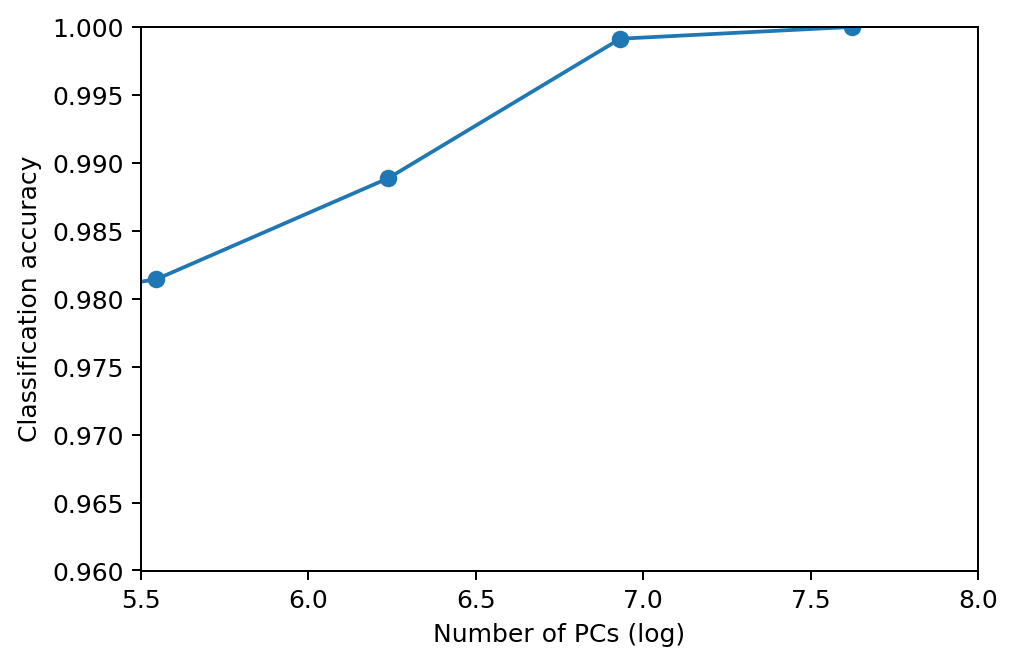

In [101]:
plt.figure(dpi=180)
plt.plot(np.log(K), accuracies)
plt.scatter(np.log(K), accuracies)
plt.xlabel('Number of PCs (log)')
plt.ylabel('Classification accuracy')
plt.xlim(5.5, 8)
plt.ylim(0.96, 1)

In [92]:
np.save('data/GSE132257/2048_PC', all_components )

### Load PCs and dataset1 split

In [3]:
all_pcs = np.load('data/GSE132257/2048_PC.npy')

In [4]:
train_ids = pd.read_csv('data/splits/ds1/cell_ID_train.tsv', sep='\t')
val_ids = pd.read_csv('data/splits/ds1/cell_ID_validation.tsv', sep='\t')
test_ids = pd.read_csv('data/splits/ds1/cell_ID_test.tsv', sep='\t')

In [25]:
train_i = train_ids.iloc[:, 1].values
val_i = val_ids.iloc[:, 1].values
test_i = test_ids.iloc[:, 1].values

# checking if there is any overlap between sets
allids = np.concatenate((train_i, val_i, test_i))
assert len(allids) == (train_ids.shape[0] + val_ids.shape[0] + test_ids.shape[0])
assert len(np.unique(allids)) == (train_ids.shape[0] + val_ids.shape[0] + test_ids.shape[0])
print('checked no overlap between sets')

print('N train:', train_ids.shape[0])
print('N val:\t', val_ids.shape[0])
print('N test:\t', test_ids.shape[0])
print('N Total:', train_ids.shape[0] + val_ids.shape[0] + test_ids.shape[0])

checked no overlap between sets
N train: 14727
N val:	 1841
N test:	 1841
N Total: 18409


In [44]:
# Split features
train_pcs = all_pcs[train_i, :]
val_pcs = all_pcs[val_i, :]
test_pcs = all_pcs[test_i, :]

# Split labels and convert to number
train_labels = annotations1.iloc[train_i]['Class'].values
val_labels = annotations1.iloc[val_i]['Class'].values
test_labels = annotations1.iloc[val_i]['Class'].values

train_labels = [labels_map[l] for l in train_labels]
val_labels = [labels_map[l] for l in val_labels]
test_labels = [labels_map[l] for l in test_labels]

## Now we do some training and clasification

### Logistic Regression with PCA features

In [46]:
from sklearn.linear_model import LogisticRegression

In [49]:
lr = LogisticRegression().fit(train_pcs, train_labels)
y_pred = lr.predict(val_pcs)
acc = (y_pred==val_labels).mean()

print('Accuracy:', acc)

Accuracy: 0.9739272134709397


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
K = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])

In [89]:
accuracies = np.empty(len(K))
for i, k in enumerate(K):
    print('K =', k)
    print('Fitting LogReg...')
    lr = LogisticRegression().fit(train_pcs[:, :k], train_labels)
    y_pred = lr.predict(val_pcs[:, :k])
    acc = (y_pred==val_labels).mean()
    accuracies[i] = acc

K = 2
Fitting LogReg...
K = 4
Fitting LogReg...
K = 8
Fitting LogReg...
K = 16
Fitting LogReg...
K = 32
Fitting LogReg...
K = 64
Fitting LogReg...
K = 128
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

K = 256
Fitting LogReg...
K = 512
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K = 1024
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K = 2048
Fitting LogReg...


/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


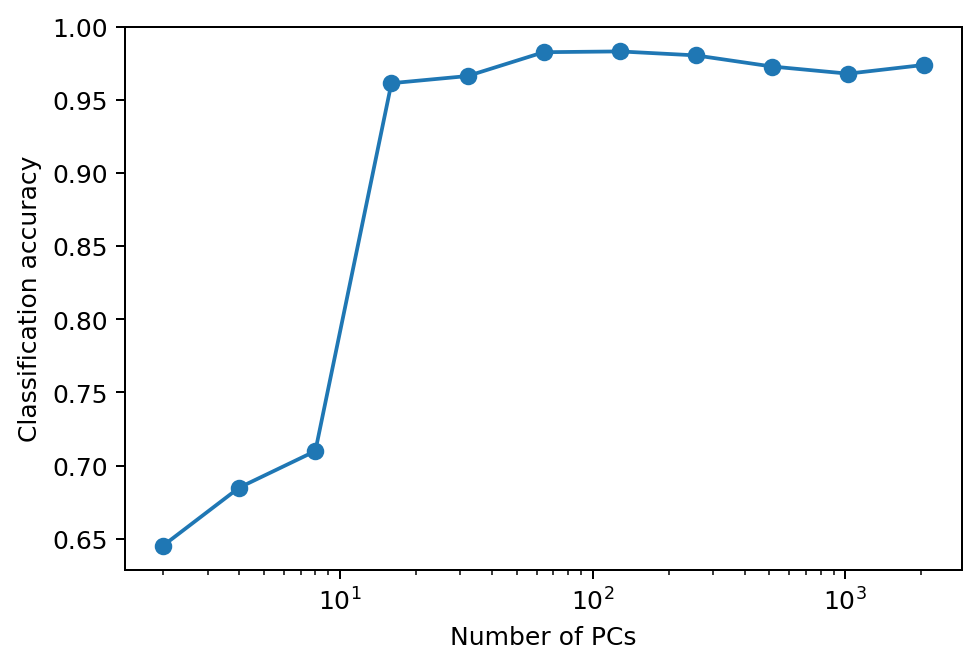

In [106]:
plt.figure(dpi=180)
ax = plt.gca()
plt.plot(K, accuracies)
plt.scatter(K, accuracies)
ax.set_xscale('log')
plt.xlabel('Number of PCs')
plt.ylabel('Classification accuracy')
for i, acc in enumerate(accuracies):
    txt = '{:2.2f}%'.format(acc*100)
    #ax.annotate(txt, (K[i], acc-0.02))
#plt.xlim(10**1, 10**3.4)
#plt.ylim(0.95, 1)
name = 'figures/logreg_PCs'
plt.savefig(f"{name}.png")
plt.savefig(f"{name}.pdf")

In [66]:
best = np.argmax(accuracies)
best_k = K[best]
print('Max accuracy is {:2.2f}% with K={:0} components'.format(accuracies[best]*100, best_k))

Max accuracy is 98.32% with K=128 components
